## 10. Approximate Inference

### 10.2 Variational Mixture of Gaussian

The class VariationalBayes_mixtureGaussian is yet another implementation of variational bayes applying to mixture Gaussian

In [1]:
import numpy as np
from numpy import log, exp
from numpy.linalg import det, inv
import scipy as sp
from scipy.stats import multivariate_normal, invwishart
from scipy.special import digamma
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from matplotlib import pyplot as plt
try:
    import seaborn as sns
except ModuleNotFoundError:
    import os
    os.system('pip install seaborn')
    import seaborn as sns

display("numpy version : " + str(np.__version__))
display("scipy version : " + str(sp.__version__))
display("pandas version : " + str(pd.__version__))
display("sklearn version : " + str(sklearn.__version__))

'numpy version : 1.16.1'

'scipy version : 1.2.0'

'pandas version : 0.22.0'

'sklearn version : 0.20.2'

In [2]:
class VariationalBayes_mixtureGaussian:
    """Exec VariationalBayes for mixtureGaussian"""
    
    def __init__(self, k):
        self.K = k                    # amount of gaussian to try to fit
        self.initialized = False

    def initialize_parameters(self, data, m_0 = None, alpha_0 = None, beta_0 = None, W_inv_0 = None, nu_0 = None):
        if self.initialized == True:
            return

        N = self.N = data.shape[0]      # Sample size
        D = self.D = data.shape[1]      # Dimension
        K = self.K                      # amount of gaussian

        if m_0 is None:
            self.m_0 = sp.stats.uniform.rvs(size=(K,D))
            self.m   = self.m_0.copy()
        else:
            self.m_0 = m_0.copy()
            self.m   = m_0.copy()

        if alpha_0 is None:
            self.alpha_0 = np.full((K,1), 1)
            self.alpha   = self.alpha_0.copy()
        else:
            self.alpha_0 = alpha_0.copy()
            self.alpha   = alpha_0.copy()

        if beta_0 is None:
            self.beta_0 = np.full((K,1), 1)
            self.beta   = self.beta_0.copy()
        else:
            self.beta_0 = beta_0.copy()
            self.beta   = beta_0.copy()

        if W_inv_0 is None:
            self.W_inv_0 = np.full((K,D,D), np.identity(D))
            self.W_inv   = self.W_inv_0.copy()
        else:
            self.W_inv_0 = W_inv_0.copy()
            self.W_inv   = W_inv_0.copy()

        if nu_0 is None:
            self.nu_0 = np.full((K,1), D)
            self.nu   = self.nu_0.copy()
        else:
            self.nu_0 = nu_0.copy()
            self.nu   = nu_0.copy()

        # Dataframe having Nk's value change for each iteration
        self.df_Nk = pd.DataFrame()

        self.initialized = True

    # Fit data by variational bayes with maltivaraate gauss distribution
    def fit(self, data, n_iter=100):
        self.X = data
        self.initialize_parameters(data)

        for i in range(0, n_iter):
            print( "Execute iteration : " + str(i) )
            r = self.exec_expectation_step()
            self.exec_maximization_step(r)

            self.add_Nk(r, i)
            if i % ( int(n_iter/5) ) == 0:
                pi, Lambda, mu = self.get_new_paramenters()
                self.draw_contour(pi, Lambda, mu)
        
    def exec_expectation_step(self):
        N = self.N; D = self.D; K = self.K

        rho = np.zeros(N*K).reshape(N,K)

        ln_tilded_Lambda = self.get_ln_tilded_Lambda()           # 10.65
        ln_tilded_Pi     = self.get_ln_tilded_Pi()               # 10.66
        for k in range(0, K):
            W_k = inv(self.W_inv[k])
            L = (self.X - self.m[k]).reshape(N,D)
            E_mu_lambda_k = D/self.beta[k] + self.nu[k]*(( L @ W_k * L ).sum(axis=1))  # 10.64
            ln_rho_k = ln_tilded_Pi[k] + ln_tilded_Lambda[k]/2.0 - D*log(2*np.pi)/2.0 - E_mu_lambda_k/2.0  # 10.46
            rho[:,k] = exp(ln_rho_k)

        sum_rho_k = rho.sum(axis=1).reshape(N,1)
        r = rho / sum_rho_k                                      # 10.49

        return r
    
    def exec_maximization_step(self, r):
        N = self.N; D = self.D; K = self.K

        N_k, x_hat, S = self.get_descriptive_statistics_values(r)     # 10.51, 10.52, 10.53

        self.alpha = self.alpha_0 + N_k                               # 10.58
        self.beta  = self.beta_0  + N_k                               # 10.60
        self.m     = (self.beta_0*self.m_0 + N_k*x_hat) / self.beta   # 10.61
        self.nu    = self.nu_0 + N_k                                  # 10.63

        for k in range(0, K):
            coef = (self.beta_0[k]*N_k[k])/(self.beta_0[k] + N_k[k])
            L = (x_hat[k] - self.m_0[k]).reshape(1,D)
            self.W_inv[k] = self.W_inv_0[k] + N_k[k] * S[k] + (coef * L).T @ L  # 10.62
            
    # The function returns values described in 10.65
    def get_ln_tilded_Lambda(self):
        sum_digamma = np.zeros_like(self.nu, dtype=float)
        for i in range(1, self.D+1):
            sum_digamma += digamma( (self.nu+1-i)/2.0 )
        return (sum_digamma + self.D*log(2) + log(det(inv(self.W_inv)).reshape(len(self.nu),-1)))          # 10.65

    # The function returns values described in 10.66
    def get_ln_tilded_Pi(self):
        return digamma(self.alpha) - digamma(self.alpha.sum(axis=0))        # B.24 & 10.66

    # The function returns descriptive statistics values described in 10.51 to 10.53
    def get_descriptive_statistics_values(self, r):
        N_k = r.sum(axis=0).reshape(self.K,1)                               # 10.51
        x_hat = np.zeros_like(self.m).reshape(self.K, self.D)
        S = np.zeros_like(self.W_inv)
        for k in range(0, self.K):
            x_hat[k] = np.sum( (r[:,k].reshape(self.N,1) * self.X), axis=0 ) / N_k[k]    # 10.52
            L = (self.X - x_hat[k]).reshape(self.N,self.D)
            S[k] = ( (r[:,k].reshape(self.N,1) * L).T @ L ) / N_k[k]        # 10.53

        return N_k, x_hat, S

    # The function returns expectation of pi, lambda, and mu of posterior
    def get_new_paramenters(self):
        pi     = self.alpha / np.sum(self.alpha, axis=0)         # B.17
        Lambda = self.nu.reshape(self.K,1,1) * inv(self.W_inv)   # B.80
        mu     = self.m                                          # B.38

        return pi, Lambda, mu

    # Draw contour and if pi, mixing coef, got to be lower than 1e-2, then omit corresponding gauss distribution.
    def draw_contour(self,pi, Lambda, mu):
        sns.scatterplot(x='eruptions_scaled', y='waiting_scaled', data=pd.DataFrame(self.X,columns=['eruptions_scaled','waiting_scaled']))
        sns.scatterplot(x='0', y='1',data=pd.DataFrame(mu,columns=['0','1']),color='red')

        x, y = np.mgrid[0:1:0.02,0:1:0.02]
        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x;    pos[:, :, 1] = y
        for k in range(0,self.K):
            rv = sp.stats.multivariate_normal(mu[k], inv(Lambda[k]))
            if pi[k] > 1e-2:
                plt.contour(x, y, pi[k]*rv.pdf(pos))
        plt.show()
    
    def add_Nk(self, r, i):
        df_Nk_temp = pd.DataFrame(r.sum(axis=0).ravel(), columns=['Nk'])
        df_Nk_temp['K'] = df_Nk_temp.index
        df_Nk_temp['iteration'] = i
        self.df_Nk = pd.concat([self.df_Nk, df_Nk_temp])

    def get_Nk(self):
        return self.df_Nk

### Appling to Old Faithful Geyser Data

,eruptions,waiting
1.0,3.600,79.0
2.0,1.800,54.0
3.0,3.333,74.0
4.0,2.283,62.0
5.0,4.533,85.0


,eruptions_scaled,waiting_scaled
0,0.571429,0.679245
1,0.057143,0.207547
2,0.495143,0.584906
3,0.195143,0.358491
4,0.838000,0.792453


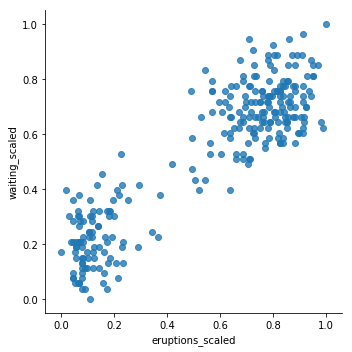

In [3]:
faithful = pd.read_csv('./faithful.csv', index_col = 0, dtype=float)
scaler = MinMaxScaler()
faithful_scaled = pd.DataFrame(scaler.fit_transform(faithful),columns=faithful.columns + "_scaled" )

display(faithful.head())
display(faithful_scaled.head())
sns.lmplot(x='eruptions_scaled', y='waiting_scaled', data=faithful_scaled, fit_reg=False)

### Dimension of variables

| variable      | Size/Dimension | Description |
|---------------|-----------|-------------|
|  N | 272 | Amount of sample data |
|  D | 2   | Dimension of data(Number of explainable variables)
|  K | 9   | Number of component |
|  X     | R(N,D)   | Observed data |
|  Z(=r) | R(N,K)   | Responsibility |
| pi     | R(K,1)   | Mixing coefficient |
| alpha  | R(K,1)   | Hyperparameter of pi, effective number of observations in Dirichlet prior |
| mu     | R(K,D)   | Center of each Gauss distribution |
|  m     | R(K,D)   | Hyperparameter of mu, mean of Gauss prior |
| beta   | R(K,1)   | Hyperparameter of mu, coefficent of precision for Gauss prior |
| Lambda | R(K,D,D) | Precision of each Gauss distribution |
|    W   | R(K,D,D) | Hyperparameter of lambda, from Wishart distribution |
|   nu   | R(K,1)   | Hyperparameter of lambda, number of degrees of freedom from Wishart distribution |


Execute iteration : 0


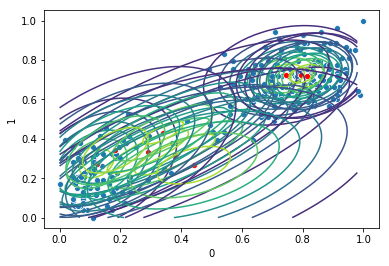

Execute iteration : 1
Execute iteration : 2
Execute iteration : 3
Execute iteration : 4
Execute iteration : 5
Execute iteration : 6
Execute iteration : 7
Execute iteration : 8
Execute iteration : 9
Execute iteration : 10
Execute iteration : 11
Execute iteration : 12
Execute iteration : 13
Execute iteration : 14
Execute iteration : 15
Execute iteration : 16
Execute iteration : 17
Execute iteration : 18
Execute iteration : 19
Execute iteration : 20


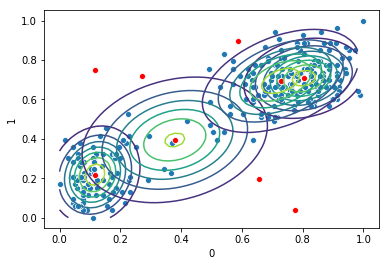

Execute iteration : 21
Execute iteration : 22
Execute iteration : 23
Execute iteration : 24
Execute iteration : 25
Execute iteration : 26
Execute iteration : 27
Execute iteration : 28
Execute iteration : 29
Execute iteration : 30
Execute iteration : 31
Execute iteration : 32
Execute iteration : 33
Execute iteration : 34
Execute iteration : 35
Execute iteration : 36
Execute iteration : 37
Execute iteration : 38
Execute iteration : 39
Execute iteration : 40


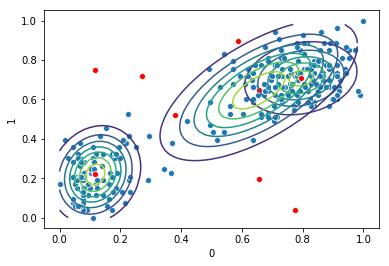

Execute iteration : 41
Execute iteration : 42
Execute iteration : 43
Execute iteration : 44
Execute iteration : 45
Execute iteration : 46
Execute iteration : 47
Execute iteration : 48
Execute iteration : 49
Execute iteration : 50
Execute iteration : 51
Execute iteration : 52
Execute iteration : 53
Execute iteration : 54
Execute iteration : 55
Execute iteration : 56
Execute iteration : 57
Execute iteration : 58
Execute iteration : 59
Execute iteration : 60


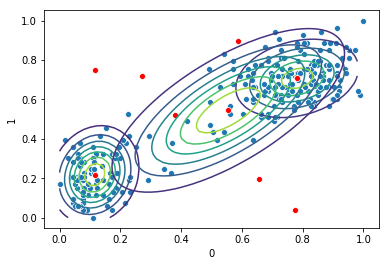

Execute iteration : 61
Execute iteration : 62
Execute iteration : 63
Execute iteration : 64
Execute iteration : 65
Execute iteration : 66
Execute iteration : 67
Execute iteration : 68
Execute iteration : 69
Execute iteration : 70
Execute iteration : 71
Execute iteration : 72
Execute iteration : 73
Execute iteration : 74
Execute iteration : 75
Execute iteration : 76
Execute iteration : 77
Execute iteration : 78
Execute iteration : 79
Execute iteration : 80


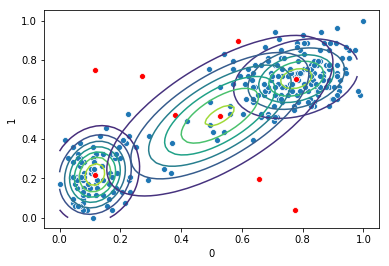

Execute iteration : 81
Execute iteration : 82
Execute iteration : 83
Execute iteration : 84
Execute iteration : 85
Execute iteration : 86
Execute iteration : 87
Execute iteration : 88
Execute iteration : 89
Execute iteration : 90
Execute iteration : 91
Execute iteration : 92
Execute iteration : 93
Execute iteration : 94
Execute iteration : 95
Execute iteration : 96
Execute iteration : 97
Execute iteration : 98
Execute iteration : 99


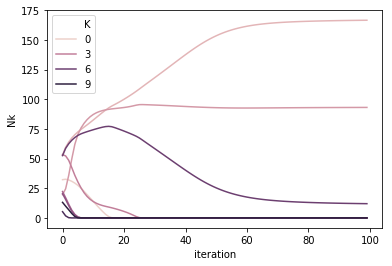

In [4]:
# 9 for gaussians
n_K = 9
D = len(faithful_scaled.columns)

m_0      = sp.stats.uniform.rvs(size=(n_K,2),random_state=20)
alpha_0  = np.full((n_K,1), 1e-2)
W_inv_0  = np.full((n_K,D,D), 1e-1*np.identity(D))

VB_MG = VariationalBayes_mixtureGaussian(k=n_K)
VB_MG.initialize_parameters(faithful_scaled.values,
                            m_0 = m_0,
                            alpha_0 = alpha_0,
                            W_inv_0 = W_inv_0)
VB_MG.fit(faithful_scaled.values, n_iter=100)

sns.lineplot(x='iteration',y='Nk',data=VB_MG.get_Nk(), hue='K')

### In the case of generated observations from 4 gaussian distribution

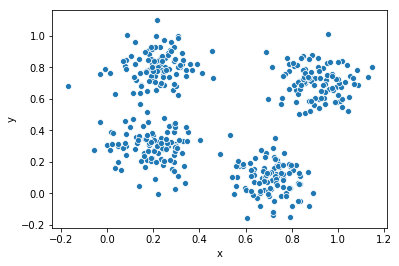

In [5]:
D_2 = 2       # Dimension
n_G_2 = 4     # Number of gaussian generates

df_GaussianData = pd.DataFrame()
mu = np.array([[0.2,0.3],[0.7,0.1],[0.9,0.7],[0.2,0.8]])
for i in range(0, n_G_2):
    # To keep data in concentration, make cov small 
    cov = 1e-2*np.identity(D_2)
    df_GaussianData = pd.concat([df_GaussianData, \
                                 pd.DataFrame(sp.stats.multivariate_normal.rvs(mu[i], cov, 100))])

df_GaussianData.columns = ['x','y']
sns.scatterplot(x='x',y='y',data=df_GaussianData)

Execute iteration : 0


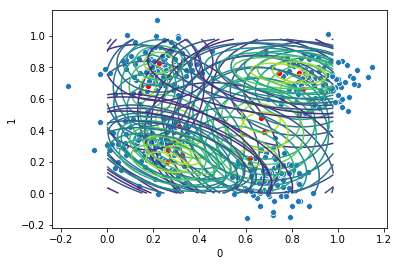

Execute iteration : 1
Execute iteration : 2
Execute iteration : 3
Execute iteration : 4
Execute iteration : 5
Execute iteration : 6
Execute iteration : 7
Execute iteration : 8
Execute iteration : 9
Execute iteration : 10
Execute iteration : 11
Execute iteration : 12
Execute iteration : 13
Execute iteration : 14
Execute iteration : 15
Execute iteration : 16
Execute iteration : 17
Execute iteration : 18
Execute iteration : 19
Execute iteration : 20


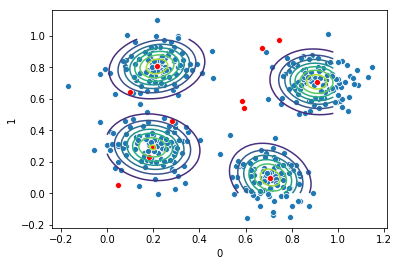

Execute iteration : 21
Execute iteration : 22
Execute iteration : 23
Execute iteration : 24
Execute iteration : 25
Execute iteration : 26
Execute iteration : 27
Execute iteration : 28
Execute iteration : 29
Execute iteration : 30
Execute iteration : 31
Execute iteration : 32
Execute iteration : 33
Execute iteration : 34
Execute iteration : 35
Execute iteration : 36
Execute iteration : 37
Execute iteration : 38
Execute iteration : 39
Execute iteration : 40


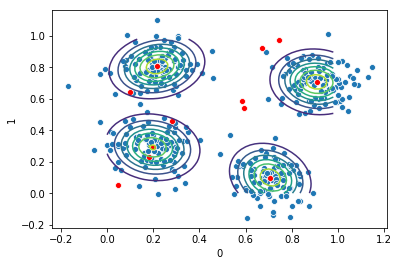

Execute iteration : 41
Execute iteration : 42
Execute iteration : 43
Execute iteration : 44
Execute iteration : 45
Execute iteration : 46
Execute iteration : 47
Execute iteration : 48
Execute iteration : 49
Execute iteration : 50
Execute iteration : 51
Execute iteration : 52
Execute iteration : 53
Execute iteration : 54
Execute iteration : 55
Execute iteration : 56
Execute iteration : 57
Execute iteration : 58
Execute iteration : 59
Execute iteration : 60


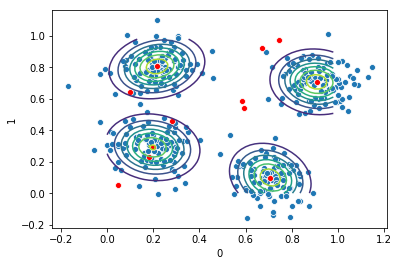

Execute iteration : 61
Execute iteration : 62
Execute iteration : 63
Execute iteration : 64
Execute iteration : 65
Execute iteration : 66
Execute iteration : 67
Execute iteration : 68
Execute iteration : 69
Execute iteration : 70
Execute iteration : 71
Execute iteration : 72
Execute iteration : 73
Execute iteration : 74
Execute iteration : 75
Execute iteration : 76
Execute iteration : 77
Execute iteration : 78
Execute iteration : 79
Execute iteration : 80


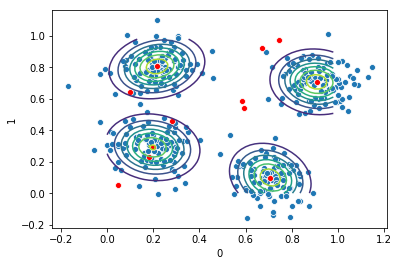

Execute iteration : 81
Execute iteration : 82
Execute iteration : 83
Execute iteration : 84
Execute iteration : 85
Execute iteration : 86
Execute iteration : 87
Execute iteration : 88
Execute iteration : 89
Execute iteration : 90
Execute iteration : 91
Execute iteration : 92
Execute iteration : 93
Execute iteration : 94
Execute iteration : 95
Execute iteration : 96
Execute iteration : 97
Execute iteration : 98
Execute iteration : 99


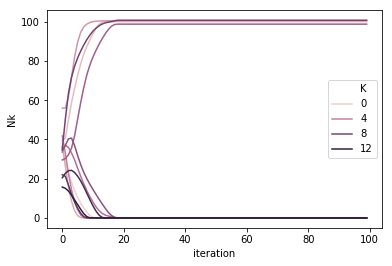

In [6]:
n_K_2 = 12
VB2 = VariationalBayes_mixtureGaussian(k=n_K_2)

m_0_2     = sp.stats.uniform.rvs(size=(n_K_2, D_2))
alpha_0_2 = np.full((n_K_2, 1), 1e-2)
W_inv_0_2 = np.full((n_K_2,D_2,D_2), 1e-1*np.identity(D_2))

VB2.initialize_parameters(data=df_GaussianData.values, m_0 = m_0_2, alpha_0 = alpha_0_2, W_inv_0 = W_inv_0_2 )
VB2.fit(data=df_GaussianData.values, n_iter=100)
sns.lineplot(x='iteration',y='Nk',data=VB2.get_Nk(), hue='K')